# Single photon analysis
Analysis for our first search for photons emitted following an excitation pulse, through $g^{(2)}$ in the future

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## 2024.05.08

## tuning SPCM gating
I've installed a TTL switch with ~ 10 ns and 5 ns rise and fall time respectively so we can block the SPCM output during at least part of the excitation pulse and during other parts of the excitation cycle as needed. the timing likely needs to be adjusted by about 10 ns, given that my initial alignment of the timing uses the switch output with a test voltage input as viewed alongside the trace of the excitation on the scope. Just based on cable lengths (fiber to the atom from excitation light, fiber from atom to SPCM, and cables to the scope), there is probably a 10-20 ns lag of the test signal I used for the switch compared to the excitation light.

In [338]:
fnames = get_files_by_criteria(date_filters=["2024-05-08"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
only_show_i_greater_than = 5 # everything before this was for looking at the FORT noise. see section below

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 12 files
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-08\12\000013147-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-08\16\000013176-GeneralVariableScan_single_photon_scan_over_gate_switch_offset.h5) scanned over gate_switch_offset
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-08\17\000013177-GeneralVariableScan_single_photon_scan_over_pumping_light_off.h5) scanned over pumping_light_off
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-08\17\000013178-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-08\17\000013179-GeneralVariableScan_single_photon_scan_over_p_excitation.h5) scanned over p_excitation
file 11 (C:\Networking Experiment\artiq codes\artiq-master\re

In [368]:
i = 7 # shows photons from an atom at gate offset = 0??
i = 8 # pumping light off/on as a test -- looks real!
# i = 9 # shows best excitation for 120 ns
# i = 10 # no strong dependence on AOM power.... weird! also I'm getting 1 and 2 photons out just as often
# i = 11 # pumping repump blocked/unblocked. again, clear signal but nearly as likely to get 1 or 2 clicks

f = h5py.File(os.path.join(results, "2024-05-08\\16\\000013174-GeneralVariableScan.h5"))
f = h5py.File(os.path.join(results, fnames[i]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot

experiment: single_photon_experiment
Pumping light off? False


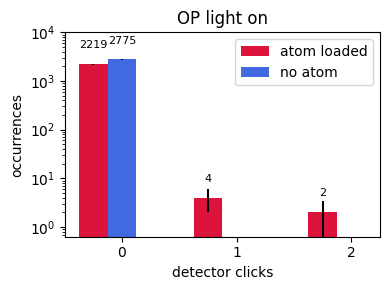

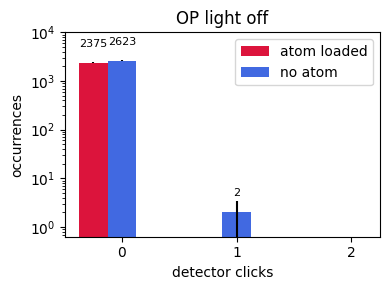

In [370]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))
units = 1e-9
unit_label = 'ns'

# units = 1
# unit_label = 'dBm'

titles = ["OP light on", "OP light off"]
use_titles = True

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:(measurements*n_excitation_cycles)*(i+1)].reshape(-1,n_excitation_cycles)
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    # print(len(photons_iteration_i))

    # plt.hist(shot1)
    
    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    mean_photons_per_cycle_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_cycle_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()
    
    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([mean_photons_per_cycle_with_atom,mean_photons_per_cycle_no_atom],barlegend,colors):
        offset = width * multiplier
        binned_data = np.histogram(data, bins=bins)[0]
        rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
        ax.bar_label(rects, padding=10, fontsize=8)
        ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
        multiplier += 1
    ax.legend(loc='upper right')

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_ylim((10**(-0.2),1e4))
    if use_titles:
        ax.set_title(titles[i])
    else:
        try:
            ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
        except TypeError: # probably a string
            ax.set_title(str(var_value)[2:-1])

    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

In [343]:
var_value

b'OP repump blocked'

In [328]:
rid

13177

experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment


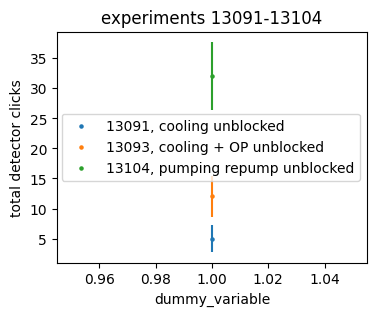

In [302]:
showhist = True
showloading = True

# scanning what time the gating starts. the gating duration is unchanged
i = 10 # cooling laser unblocked, but no atoms loaded. still using short MOT time

# the FORT is unblocked for all of the measurements below, but otherwise the beams not specified are physically blocked.
# I entered the variable names manaully because the duplicate files which I save with helpful names didn't save due to underflow errors.
# the default h5 file created by ARTIQ saves even if run() fails.
rids = []
fig,ax = plt.subplots(figsize=(4,3))
fnames_dict = {
    6:'cooling unblocked',
    '2024-05-07\\20\\000013093-GeneralVariableScan.h5':'cooling + OP unblocked',
    '2024-05-07\\20\\000013104-GeneralVariableScan.h5':'pumping repump unblocked',
    # '2024-05-07\\20\\000013105-GeneralVariableScan.h5':'everything unblocked'
}
for fname,desc in fnames_dict.items():
    if fname in list(range(len(fnames))):
        fname = fnames[i]
    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    rids.append(rid)
    
    counts_by_iteration = []
    
    for j, var_value in zip(range(iterations),scan_sequence1):
    
        photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*j:(measurements*n_excitation_cycles)*(j+1)].reshape(-1,n_excitation_cycles)
        shot1 = photocounts[j*measurements:(j+1)*measurements]
    
        counts_by_iteration.append(np.sum(photons_iteration_i))
        
    
    ax.scatter(scan_sequence1, counts_by_iteration,s=5,label=str(rid)+', '+desc)
    ax.errorbar(scan_sequence1, counts_by_iteration, yerr=[np.sqrt(x) for x in counts_by_iteration])
ax.legend()
ax.set_ylabel('total detector clicks')
ax.set_xlabel(scan_variable1_name)
ax.set_title(f"experiments {rids[0]}-{rids[-1]}")

plt.show()

In [293]:
len(photons_iteration_i)

953

In [282]:
counts_by_iteration

[0, 0]

### seeing how photons from the FORT depend on the start time of ttl gate_rising
Below it can be seen that if the ttl gate_rising call is pushed 700 mu into the future compared to what we were doing previously, there are no photons detected. note that I physically blocked all other beams.

In [280]:
fnames = get_files_by_criteria(date_filters=["2024-05-07"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 10 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\13\000013061-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\14\000013066-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\15\000013081-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\16\000013083-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\16\000013084-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 5 (C:\Networkin

## 2024.05.07

## tracking down noise
measurements yesterday suggested that the majority of counts come from the FORT. we want to mitigate these counts as much as possible by proper tuning of the experiment (making sure the FORT is all the way off when we start counting, e.g.), but we can also implement switching of the SPCM output with a fast switch. the SPCM gating latency is not short enough for this purpose. 

in the experiments below that investigate counts, I have reduced the MOT loading time to 10 ms so we can improve the data rate.

### checking counts from other lasers
Now that the noise from the FORT should be negligible, what about the other beams?

In [300]:
fnames = get_files_by_criteria(date_filters=["2024-05-07"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
only_show_i_greater_than = 9 # everything before this was for looking at the FORT noise. see section below

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 10 files


experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment


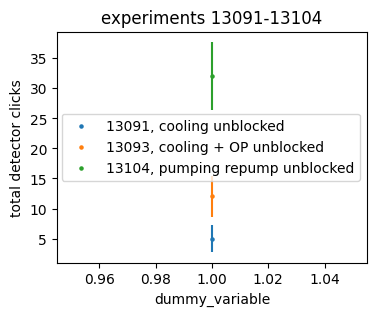

In [302]:
showhist = True
showloading = True

# scanning what time the gating starts. the gating duration is unchanged
i = 10 # cooling laser unblocked, but no atoms loaded. still using short MOT time

# the FORT is unblocked for all of the measurements below, but otherwise the beams not specified are physically blocked.
# I entered the variable names manaully because the duplicate files which I save with helpful names didn't save due to underflow errors.
# the default h5 file created by ARTIQ saves even if run() fails.
rids = []
fig,ax = plt.subplots(figsize=(4,3))
fnames_dict = {
    '2024-05-07\\19\\000013091-GeneralVariableScan.h5':'cooling unblocked',
    '2024-05-07\\20\\000013093-GeneralVariableScan.h5':'cooling + OP unblocked',
    '2024-05-07\\20\\000013104-GeneralVariableScan.h5':'pumping repump unblocked',
    # '2024-05-07\\20\\000013105-GeneralVariableScan.h5':'everything unblocked'
}
for fname,desc in fnames_dict.items():
    if fname in list(range(len(fnames))):
        fname = fnames[i]
    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    rids.append(rid)
    
    counts_by_iteration = []
    
    for j, var_value in zip(range(iterations),scan_sequence1):
    
        photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*j:(measurements*n_excitation_cycles)*(j+1)].reshape(-1,n_excitation_cycles)
        shot1 = photocounts[j*measurements:(j+1)*measurements]
    
        counts_by_iteration.append(np.sum(photons_iteration_i))
        
    
    ax.scatter(scan_sequence1, counts_by_iteration,s=5,label=str(rid)+', '+desc)
    ax.errorbar(scan_sequence1, counts_by_iteration, yerr=[np.sqrt(x) for x in counts_by_iteration])
ax.legend()
ax.set_ylabel('total detector clicks')
ax.set_xlabel(scan_variable1_name)
ax.set_title(f"experiments {rids[0]}-{rids[-1]}")

plt.show()

In [293]:
len(photons_iteration_i)

953

In [282]:
counts_by_iteration

[0, 0]

### seeing how photons from the FORT depend on the start time of ttl gate_rising
Below it can be seen that if the ttl gate_rising call is pushed 700 mu into the future compared to what we were doing previously, there are no photons detected. note that I physically blocked all other beams.

In [280]:
fnames = get_files_by_criteria(date_filters=["2024-05-07"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 10 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\13\000013061-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\14\000013066-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\15\000013081-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\16\000013083-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-07\16\000013084-GeneralVariableScan_single_photon_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 5 (C:\Networkin

experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment
experiment: single_photon_experiment


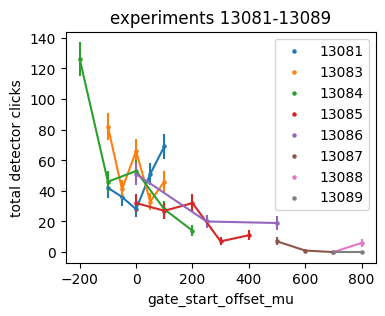

In [281]:
showhist = True
showloading = True

# scanning what time the gating starts. the gating duration is unchanged
i = 2 # the cooling, D1, pumping repump, MOT repump, and excitation are all physically blocked, leaving only the FORT on. I disabled feedback to the AOMs except the FORT for this and set the MOT loading to 10 ms; see ARTIQ code manual.
i = 3 # identical to above.
i = 4 # twice the scan range, otherwise identical to above.
i = 5 # scan range is positive, going to farther out times in the future
i = 9 # I pushed the time the FORT comes back at the end of an excitation cycle into the future

rids = []
fig,ax = plt.subplots(figsize=(4,3))
for i in range(2,10):
    f = h5py.File(os.path.join(results, fnames[i]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    rids.append(rid)

    counts_by_iteration = []
    
    for j, var_value in zip(range(iterations),scan_sequence1):
    
        photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*j:(measurements*n_excitation_cycles)*(j+1)].reshape(-1,n_excitation_cycles)
        shot1 = photocounts[j*measurements:(j+1)*measurements]
    
        counts_by_iteration.append(np.sum(photons_iteration_i))
        
    
    ax.scatter(scan_sequence1, counts_by_iteration,s=5,label=rid)
    ax.errorbar(scan_sequence1, counts_by_iteration, yerr=[np.sqrt(x) for x in counts_by_iteration])
    ax.legend()
    ax.set_ylabel('total detector clicks')
    ax.set_xlabel(scan_variable1_name)
    ax.set_title(f"experiments {rids[0]}-{rids[-1]}")

plt.show()


In [282]:
counts_by_iteration

[0, 0]

In [270]:
(n_measurements*n_excitation_cycles*n_excitation_attempts*(t_excitation_pulse + 100e-9))*280

1.5750000000000002

In [260]:
[1/np.sqrt(x) for x in counts_by_iteration]

[0.14002800840280097, 0.22360679774997896, 0.22941573387056174]

1000


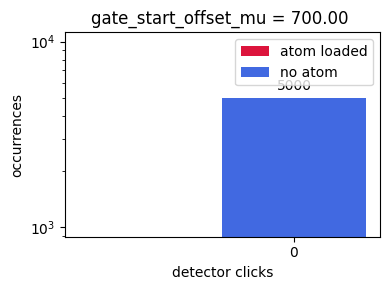

1000


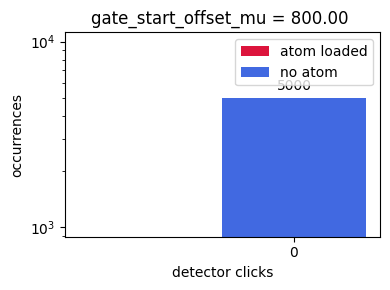

In [283]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))
units = 1 #1e-9
unit_label = ''#'ns'

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:(measurements*n_excitation_cycles)*(i+1)].reshape(-1,n_excitation_cycles)
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    print(len(photons_iteration_i))
    # print(len(photons_iteration_i))

    # plt.hist(shot1)
    
    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    mean_photons_per_cycle_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_cycle_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()
    
    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([mean_photons_per_cycle_with_atom,mean_photons_per_cycle_no_atom],barlegend,colors):
        offset = width * multiplier
        rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.legend(loc='upper right')

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

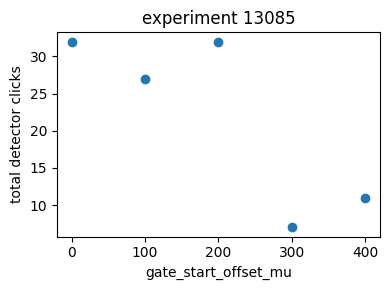

In [249]:
counts_by_iteration = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:(measurements*n_excitation_cycles)*(i+1)].reshape(-1,n_excitation_cycles)
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    counts_by_iteration.append(np.sum(photons_iteration_i))
    
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(scan_sequence1, counts_by_iteration)

ax.set_ylabel('total detector clicks')
ax.set_xlabel(scan_variable1_name)
ax.set_title(f"experiment {rid}")
# ax.legend(loc='upper left', ncols=3)

fig.tight_layout()
plt.show()

## 2024.05.06

## continued search for single photons, background measurement
scroll down for histogram of detector clicks with and without an atom loaded. 

in order to measure the background, I've unlocked the cooling laser (see experiment 13001) and run the single_photon_experiment with 5 and 5 excitation cycles and attempts.

to-do: check that the AOM rise time for 1st order is accurately represented by the 0th order dip I'm measuring. Akbar got a pulse < 50 ns.

In [213]:
fnames = get_files_by_criteria(date_filters=["2024-05-06"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\11\000013003-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5, which is corrupt
found 7 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\10\000013001-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\10\000013002-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\12\000013004-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\14\000013006-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-06\14\000

experiment: single_photon_experiment
Pumping light off? False


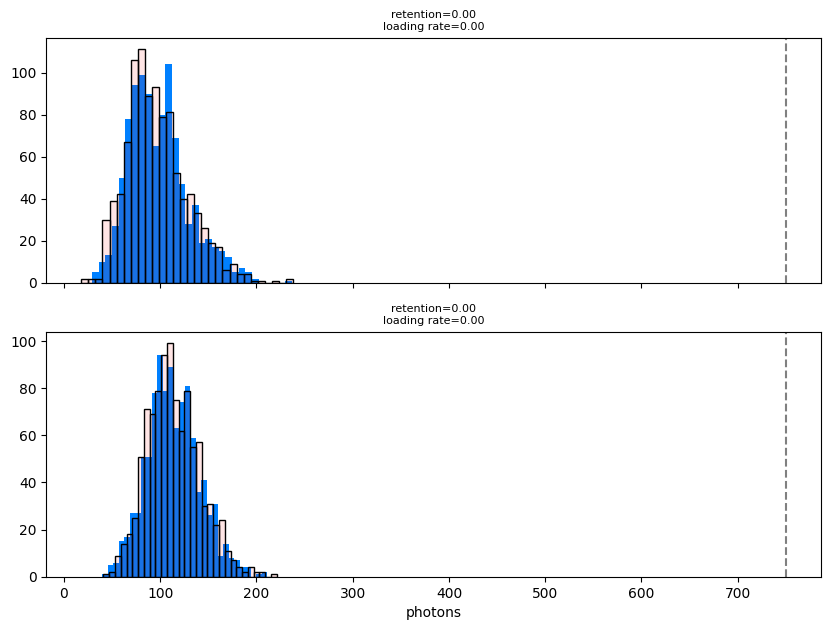

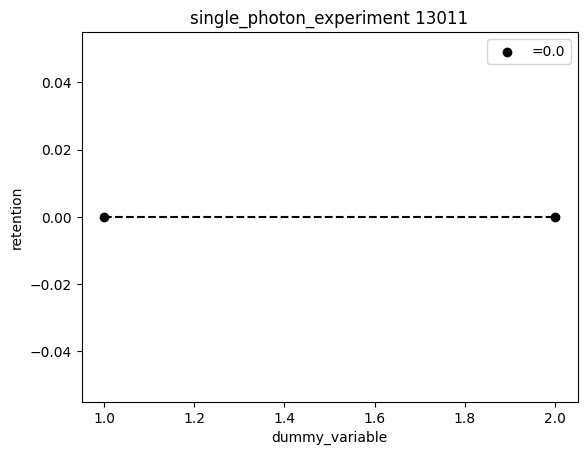

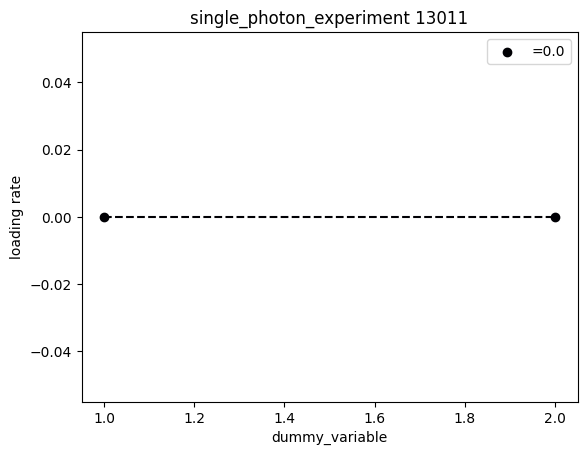

In [214]:
showhist = True
showloading = True

i = 0 # cooling laser unlocked to measure background with no atoms
i = 1 # cooling laser locked, same experiment as above
i = 2 # same experiment, excitation light physically blocked
i = 3 # repump physically blocked
i = 4 # cooling physically blocked
i = 5 # D1 OP light blocked
i = 6 # FORT blocked

f = h5py.File(os.path.join(results, fnames[i]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

1000


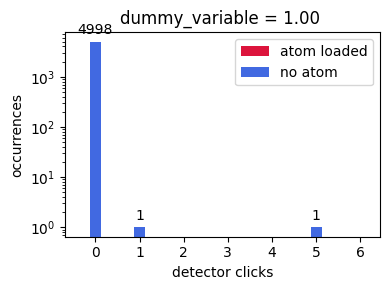

1000


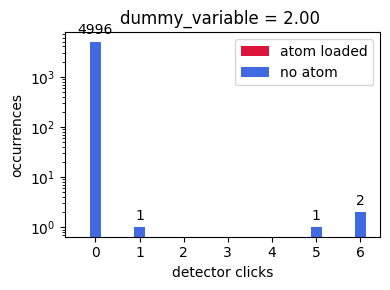

In [215]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))
units = 1 #1e-9
unit_label = ''#'ns'

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:(measurements*n_excitation_cycles)*(i+1)].reshape(-1,n_excitation_cycles)
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    print(len(photons_iteration_i))
    # print(len(photons_iteration_i))

    # plt.hist(shot1)
    
    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    mean_photons_per_cycle_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_cycle_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()
    
    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([mean_photons_per_cycle_with_atom,mean_photons_per_cycle_no_atom],barlegend,colors):
        offset = width * multiplier
        rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.legend(loc='upper right')

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

1000


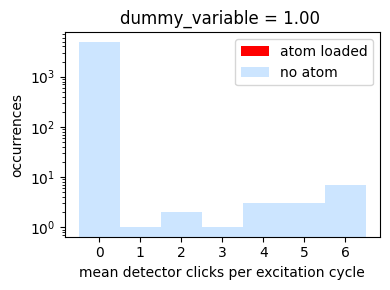

1000


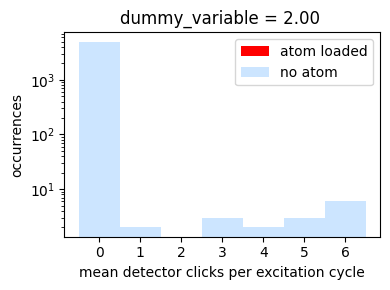

In [201]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))

xlabels = [str(x) for x in range(max_counts)]
barlegend = ["atom loaded","no atom"]
colors = [(1.0, 0.0, 0.0, 1), (.0, 0.5, 1, .2)]
x = np.arange(len(xlabels))  # the label locations

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:(measurements*n_excitation_cycles)*(i+1)].reshape(-1,n_excitation_cycles)
    print(len(photons_iteration_i))
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    
    mean_photons_per_cycle_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_cycle_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()
    # print(len(mean_photons_per_excitation_with_atom)+len(mean_photons_per_excitation_no_atom))
    
    # mean_photons_with_atom_list.append(mean_photons_per_excitation_with_atom)

    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip(
        [mean_photons_per_cycle_with_atom,mean_photons_per_cycle_no_atom],barlegend,colors):
        rects = ax.hist(data, bins=bins, label=label, facecolor=color)
    ax.legend(loc='upper right')

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('mean detector clicks per excitation cycle')
    ax.set_xticks(x+0.5, x)
    ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

## 2024.05.04

## continued search for single photons
scroll down for histogram of detector clicks with and without an atom loaded. 

I realized that in my code from yesterday, each element in excitation_counts was the number of detector clicks over all excitation cycles in a given measurement. In other words, if I'm doing n_excitation_cycles and n_excitation_attempts within one of those, then the number of clicks reported is the number counted over the whole n_excitation_cycles and n_excitation_attempts, and I should have been dividing by that number. Now, my code has the excitation counts for a single excitation_cycle, i.e. the counts after a series of n_excitation_attempts. I still need to divide by that number.

In [136]:
fnames = get_files_by_criteria(date_filters=["2024-05-04"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-04\09\000012967-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-04\10\000012977-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-04\11\000012978-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse


experiment: single_photon_experiment
Pumping light off? False


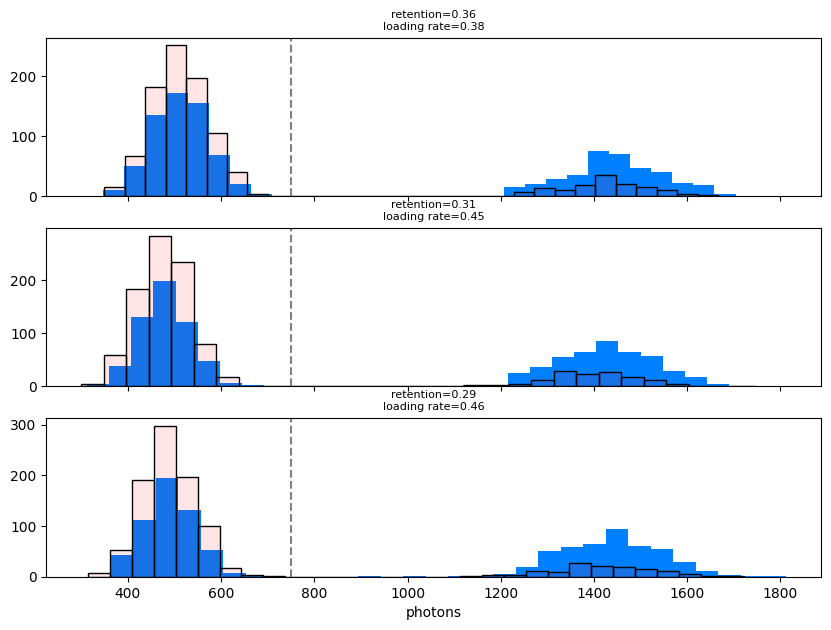

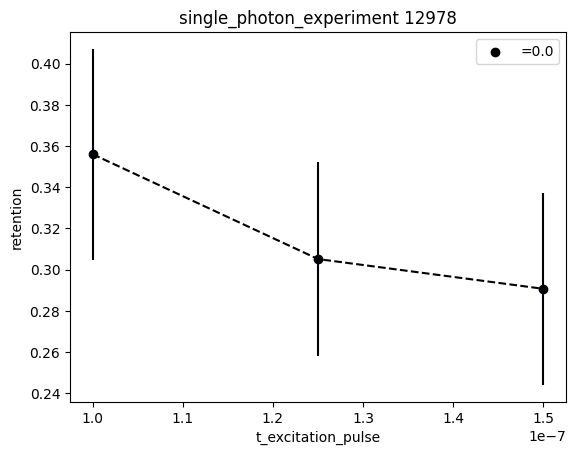

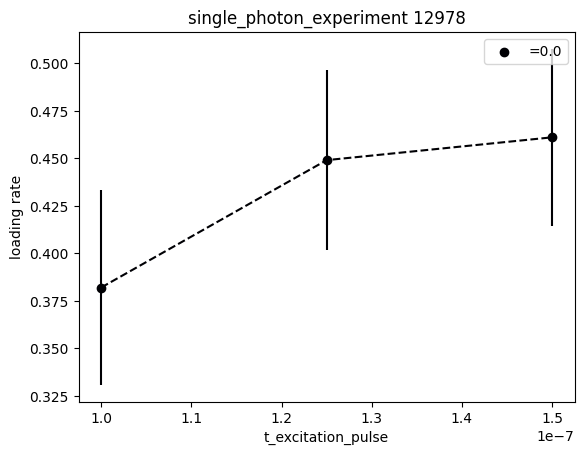

In [103]:
showhist = True
showloading = True

i = 2 # scan over excitation pulse time

f = h5py.File(os.path.join(results, fnames[i]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

In [107]:
excitation_counts[1:][:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [115]:
np.arange(10).reshape(-1,2).flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

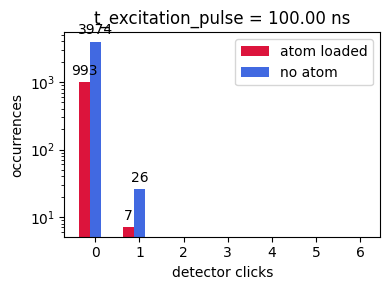

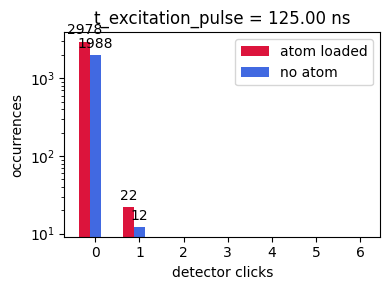

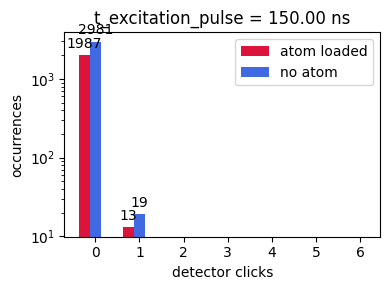

In [138]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))
units = 1e-9
unit_label = 'ns'

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:measurements*n_excitation_cycles*(i+1)].reshape(n_excitation_cycles,-1)
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    mean_photons_per_excitation_with_atom = np.array([p/n_excitation_attempts for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_excitation_no_atom = np.array([p/n_excitation_attempts for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()

    mean_photons_with_atom_list.append(mean_photons_per_excitation_with_atom)
    
    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([mean_photons_per_excitation_with_atom,mean_photons_per_excitation_no_atom],barlegend,colors):
        offset = width * multiplier
        rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.legend(loc='upper right')
    # ax.bar(x, np.histogram(photons_iteration_i, bins=bins)[0])

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

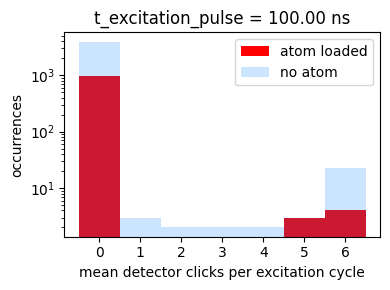

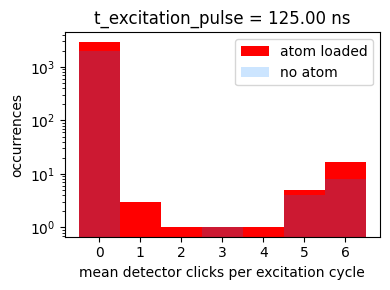

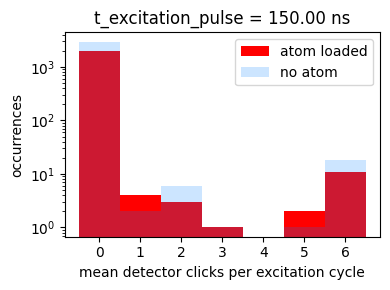

In [158]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))

xlabels = [str(x) for x in range(max_counts)]
barlegend = ["atom loaded","no atom"]
colors = [(1.0, 0.0, 0.0, 1), (.0, 0.5, 1, .2)]
x = np.arange(len(xlabels))  # the label locations

mean_photons_with_atom_list = []

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[1:][measurements*n_excitation_cycles*i:measurements*n_excitation_cycles*(i+1)].reshape(n_excitation_cycles,-1)
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    
    mean_photons_per_cycle_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1]).flatten()
    mean_photons_per_cycle_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1]).flatten()
    # print(len(mean_photons_per_excitation_with_atom)+len(mean_photons_per_excitation_no_atom))
    
    mean_photons_with_atom_list.append(mean_photons_per_excitation_with_atom)

    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip(
        [mean_photons_per_cycle_with_atom,mean_photons_per_cycle_no_atom],barlegend,colors):
        rects = ax.hist(data, bins=bins, label=label, facecolor=color)
    ax.legend(loc='upper right')

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('mean detector clicks per excitation cycle')
    ax.set_xticks(x+0.5, x)
    ax.set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

In [152]:
mean_photons_per_cycle_with_atom

array([0, 0, 0, ..., 0, 0, 0])

In [131]:
for i in range(len(scan_sequence1)):
    print(f"mean photons per excitation with {scan_variable1_name} = {scan_sequence1[i]}")
    print(set(mean_photons_with_atom_list[i]))

mean photons per excitation with t_excitation_pulse = 1.0000000000000001e-07
{0.0, 1.2, 1.0}
mean photons per excitation with t_excitation_pulse = 1.2500000000000002e-07
{0.0, 1.2, 0.2, 1.0, 0.4, 0.8, 0.6}
mean photons per excitation with t_excitation_pulse = 1.5000000000000002e-07
{0.0, 1.2, 0.2, 1.0, 0.4, 0.6}


## 2024.05.03

## second search for single photons
scroll down for histogram of detector clicks with and without an atom loaded. 

we realized today that the excitation light was being completely blocked by the polarizer in the chamber, as the light had been erroneously aligned to the slow axis of the fiber (possibly the fiber splice was 90 deg off), while it needed to be aligned to the fast axis. This was fixed, and the last experiment from today is an AOM power scan after this fix. 

In [97]:
# fnames = get_files_by_criteria(date_filters=["2024-05-02"], # only find files from these date directories
fnames = get_files_by_criteria(date_filters=["2024-05-03"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 5 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-03\11\000012949-GeneralVariableScan_single_photon_scan_over_p_excitation.h5) scanned over p_excitation
oops... something wrong with C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-03\13\000012951-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-03\14\000012953-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-03\15\000012958-GeneralVariableScan_single_photon_scan_over_t_excitation_pulse.h5) scanned over t_excitation_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-03\17\000012966-GeneralVariableScan_single_photon_scan_over_p_excitation.h5) scanned over p_excitation


experiment: single_photon_experiment
Pumping light off? False


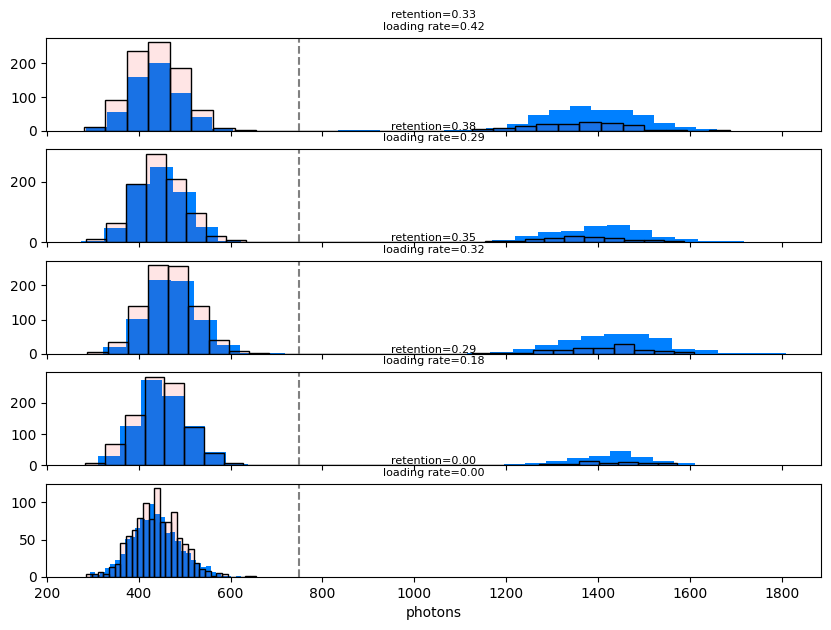

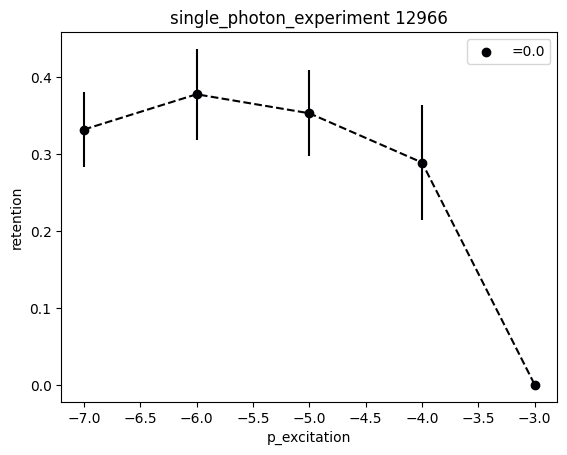

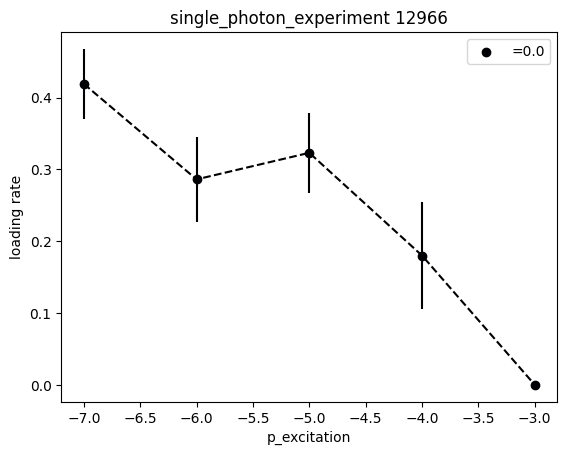

In [98]:
showhist = True
showloading = True

i = 9 # from 2024-05-02. doesn't show any sign of real single photons
i = 0 # scan over AOM power after sending slightly more power to excitation setup
i = 4 # scan over AOM power after correcting alignment to fiber axis of GRIN1


f = h5py.File(os.path.join(results, fnames[i]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

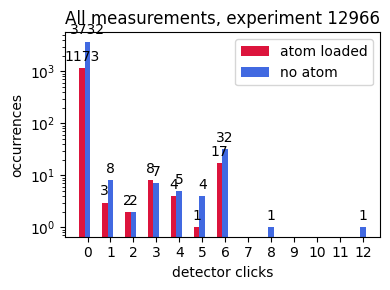

In [99]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))

photons = excitation_counts
shot1 = photocounts

xlabels = [str(x) for x in range(max_counts)]
barlegend = ["atom loaded","no atom"]
colors = ['crimson','royalblue']
x = np.arange(len(xlabels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

photons_with_atom = np.array([p for p,s in zip(photons,shot1) if s > cutoff1])
photons_no_atom = np.array([p for p,s in zip(photons,shot1) if s <= cutoff1])

fig,ax = plt.subplots(figsize=(4,3))
for data, label, color in zip([photons_with_atom,photons_no_atom],barlegend,colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(loc='upper right')
# ax.bar(x, np.histogram(photons_iteration_i, bins=bins)[0])

ax.set_yscale('log')
ax.set_ylabel('occurrences')
ax.set_xlabel('detector clicks')
ax.set_xticks(x + width, x)
ax.set_title(f"All measurements, experiment {rid}")
# ax.legend(loc='upper left', ncols=3)

fig.tight_layout()
plt.show()

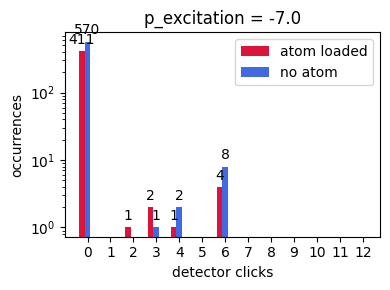

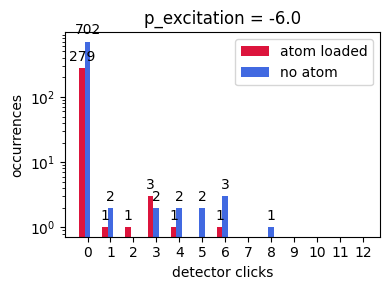

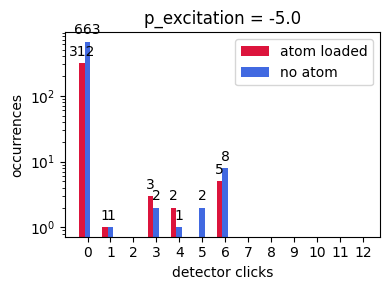

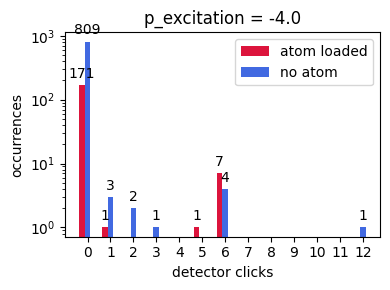

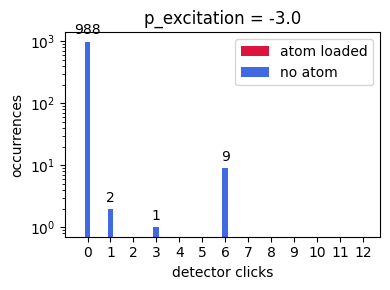

In [100]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[measurements*i:measurements*(i+1)]
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    photons_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1])
    photons_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1])

    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([photons_with_atom,photons_no_atom],barlegend,colors):
        offset = width * multiplier
        rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.legend(loc='upper right')
    # ax.bar(x, np.histogram(photons_iteration_i, bins=bins)[0])

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_title(f"{scan_variable1_name} = {var_value}")
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()

## 2024.05.02

## first search for single photons
scroll down for histogram of detector clicks with and without an atom loaded. no sign of real photons yet.

In [81]:
fnames = get_files_by_criteria(date_filters=["2024-05-01"], # only find files from these date directories
                               name_filters=["single_photon", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
only_show_i_greater_than = 14 # everything before this was just for debugging the pulse timing

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 16 files
file 15 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-01\16\000012830-GeneralVariableScan_single_photon_scan_over_p_excitation.h5) scanned over p_excitation


experiment: single_photon_experiment
Pumping light off? False


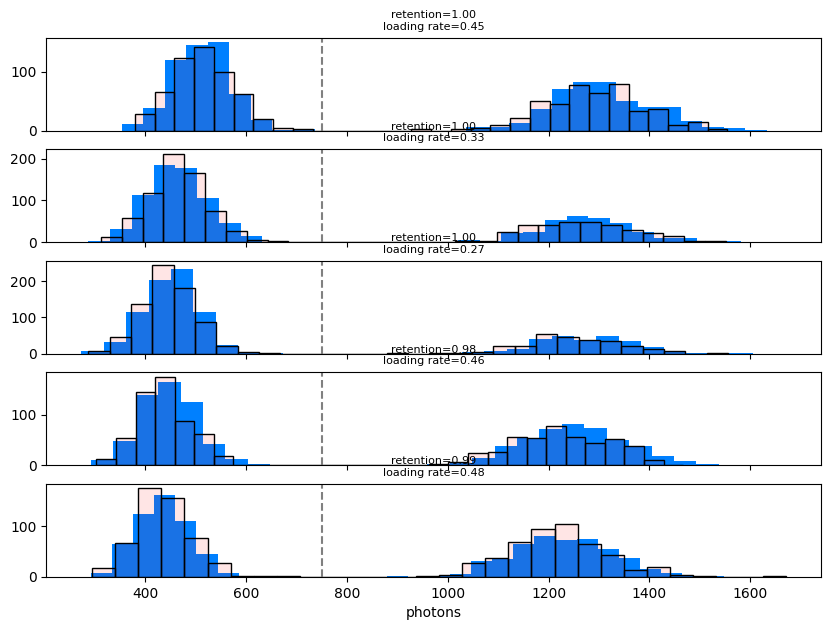

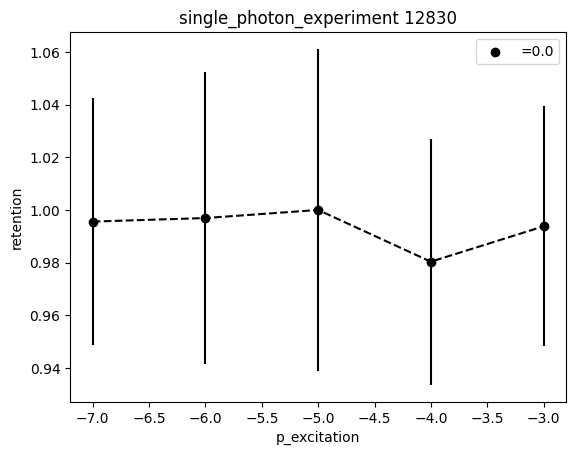

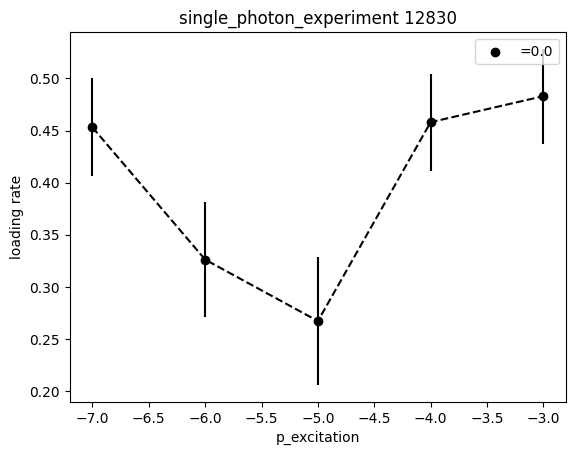

In [82]:
showhist = True
showloading = True

fname = fnames[15]

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

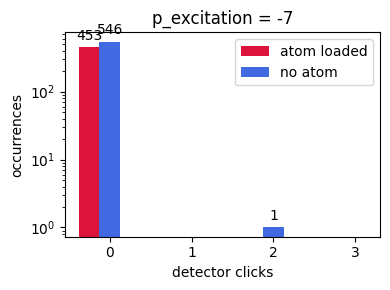

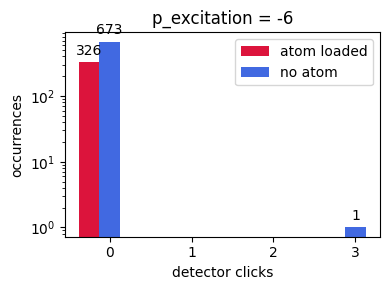

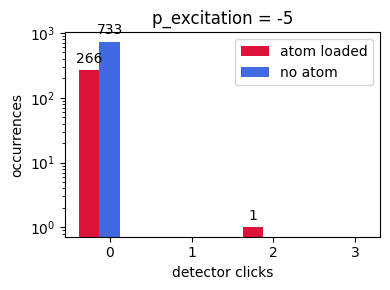

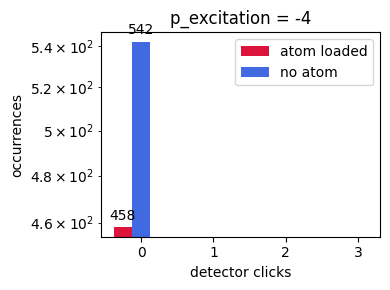

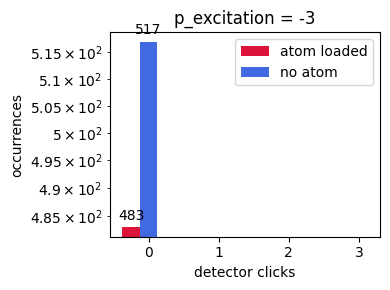

In [84]:
max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))

for i, var_value in zip(range(iterations),scan_sequence1):

    photons_iteration_i = excitation_counts[measurements*i:measurements*(i+1)]
    shot1 = photocounts[i*measurements:(i+1)*measurements]

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    photons_with_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s > cutoff1])
    photons_no_atom = np.array([p for p,s in zip(photons_iteration_i,shot1) if s <= cutoff1])

    fig,ax = plt.subplots(figsize=(4,3))
    for data, label, color in zip([photons_with_atom,photons_no_atom],barlegend,colors):
        offset = width * multiplier
        rects = ax.bar(x + offset, np.histogram(data, bins=bins)[0], width, label=label, color=color)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.legend(loc='upper right')
    # ax.bar(x, np.histogram(photons_iteration_i, bins=bins)[0])

    ax.set_yscale('log')
    ax.set_ylabel('occurrences')
    ax.set_xlabel('detector clicks')
    ax.set_xticks(x + width, x)
    ax.set_title(f"{scan_variable1_name} = {var_value}")
    # ax.legend(loc='upper left', ncols=3)

    fig.tight_layout()
    plt.show()